# Engagement EDA

This notebook explores product-level engagement patterns from `analytics.fct_product_daily_engagement`.

**Goals**
- Validate dataset coverage and basic data quality
- Understand the distribution and time dynamics of engagement
- Identify products with stable vs volatile usage patterns

> Engagement is a *usage* signal, not a direct learning outcome.

In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- plotting defaults ----
plt.rcParams["figure.figsize"] = (10, 5)

# ---- connect ----
DB_PATH = "../warehouse/edtech_engagement.duckdb"
con = duckdb.connect(DB_PATH)

def q(sql: str) -> pd.DataFrame:
    """Run a SQL query against DuckDB and return a DataFrame."""
    return con.execute(sql).df()

def pct(n, d) -> float:
    return (float(n) / float(d) * 100.0) if d else 0.0

def sql_in_list(values):
    """Create a safe-ish SQL IN (...) list for simple ints/strings."""
    lits = []
    for v in values:
        if v is None:
            continue
        if isinstance(v, (int, np.integer)):
            lits.append(str(int(v)))
        else:
            s = str(v).replace("'", "''")
            lits.append("'" + s + "'")
    return "(" + ",".join(lits) + ")" if lits else "(NULL)"

con

## 1. Inspect available tables

In [2]:
q("""
SELECT table_schema, table_name
FROM information_schema.tables
WHERE table_schema = 'analytics'
ORDER BY table_name
""")

,table_schema,table_name
0,analytics,dim_products
1,analytics,fct_daily_engagement
2,analytics,fct_daily_engagement_unknown_product
3,analytics,fct_product_daily_engagement
4,analytics,my_first_dbt_model
5,analytics,my_second_dbt_model
6,analytics,raw_districts
7,analytics,raw_engagement
8,analytics,raw_products
9,analytics,stg_districts


## 2. Preview `analytics.fct_product_daily_engagement`

In [3]:
q("""
SELECT *
FROM analytics.fct_product_daily_engagement
LIMIT 10
""")

,lp_id,usage_date,avg_pct_access,avg_engagement_index
0,26488,2020-05-20,8.235,3007.240
1,17941,2020-05-21,1.250,38.890
2,51853,2020-05-22,0.140,2.670
3,73101,2020-05-22,0.330,29.250
4,32213,2020-05-28,19.125,7722.790
5,51853,2020-05-30,0.170,6.740
6,90153,2020-05-31,0.085,12.640
7,61945,2020-06-01,1.175,75.905
8,87762,2020-06-08,0.040,1.680
9,85682,2020-06-10,0.040,0.840


In [4]:
q("""
SELECT table_name, table_type
FROM information_schema.tables
WHERE table_schema = 'analytics'
""")


,table_name,table_type
0,my_first_dbt_model,BASE TABLE
1,raw_districts,BASE TABLE
2,raw_engagement,BASE TABLE
3,raw_products,BASE TABLE
4,dim_products,VIEW
5,fct_daily_engagement,VIEW
6,fct_daily_engagement_unknown_product,VIEW
7,fct_product_daily_engagement,VIEW
8,my_second_dbt_model,VIEW
9,stg_districts,VIEW


In [5]:
q("DESCRIBE edtech_engagement.analytics.stg_engagement")


,column_name,column_type,null,key,default,extra
0,usage_date,DATE,YES,None,None,None
1,lp_id,BIGINT,YES,None,None,None
2,pct_access,DOUBLE,YES,None,None,None
3,engagement_index,DOUBLE,YES,None,None,None


## 3. Coverage & data quality checks

In [6]:
coverage = q("""
SELECT
    COUNT(*) AS n_rows,
    COUNT(DISTINCT usage_date) AS n_days,
    MIN(usage_date) AS min_date,
    MAX(usage_date) AS max_date,
    COUNT(DISTINCT lp_id) AS n_products,
    SUM(CASE WHEN lp_id IS NULL THEN 1 ELSE 0 END) AS n_missing_lp_id,
    SUM(CASE WHEN avg_engagement_index IS NULL THEN 1 ELSE 0 END) AS n_missing_engagement
FROM analytics.fct_product_daily_engagement
""")
coverage

,n_rows,n_days,min_date,max_date,n_products,n_missing_lp_id,n_missing_engagement
0,153864,366,2020-01-01,2020-12-31,4822,0.0,34439.0


In [7]:
q("""
SELECT
    usage_date,
    lp_id,
    COUNT(*) AS n
FROM analytics.fct_product_daily_engagement
GROUP BY 1, 2
HAVING COUNT(*) > 1
ORDER BY n DESC
LIMIT 20
""")

,usage_date,lp_id,n


### Data quality note

If a non-trivial share of rows are missing `lp_id`, product-level results will be incomplete for unmapped products.

For product-level sections below, we exclude rows where `lp_id` is NULL.

In [8]:
n_rows = int(coverage.loc[0, "n_rows"])
n_missing = int(coverage.loc[0, "n_missing_lp_id"])
print(f"Rows: {n_rows:,}")
print(f"Rows missing lp_id: {n_missing:,} ({pct(n_missing, n_rows):.2f}%)")

Rows: 153,864
Rows missing lp_id: 0 (0.00%)


## 4. Distribution of engagement

A distribution view helps determine whether engagement is broadly distributed or dominated by a long tail of product-days.

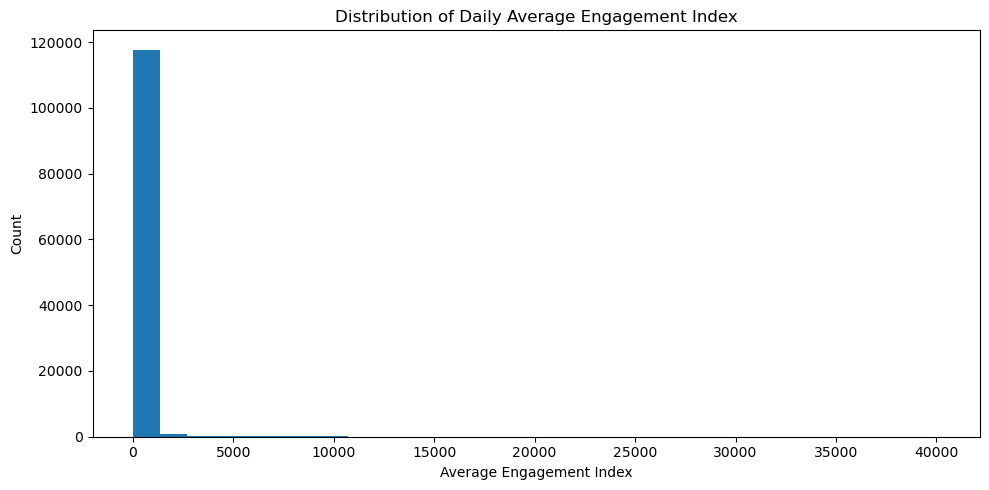

,avg_engagement_index
count,119425.000000
mean,108.454351
std,785.915997
min,0.050000
25%,0.520000
50%,2.400000
75%,16.180000
max,40162.823333


In [9]:
dist = q("""
SELECT avg_engagement_index
FROM analytics.fct_product_daily_engagement
WHERE avg_engagement_index IS NOT NULL
""")

ax = dist["avg_engagement_index"].plot(kind="hist", bins=30)
ax.set_title("Distribution of Daily Average Engagement Index")
ax.set_xlabel("Average Engagement Index")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

dist.describe()

## 5. Overall engagement over time

This is a quick read for seasonality, step-changes, or general drift.

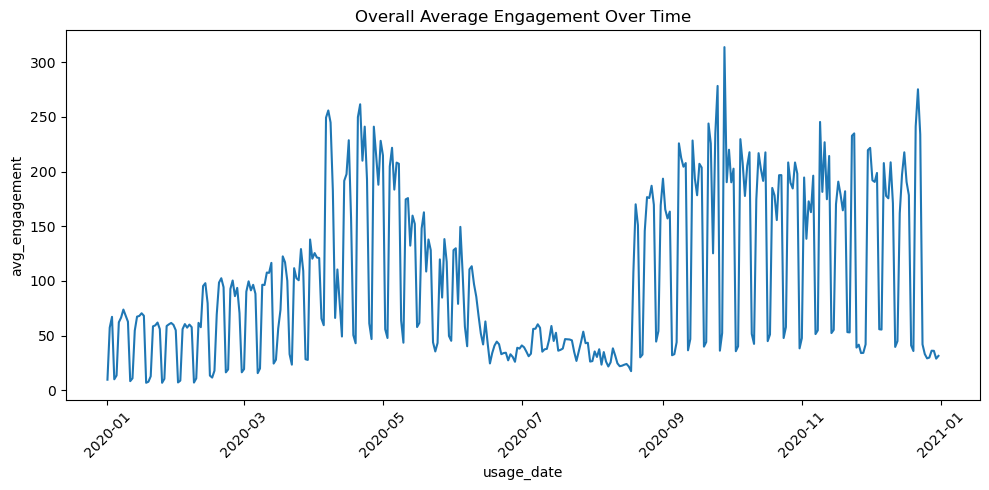

,usage_date,avg_engagement
361,2020-12-27,29.869200
362,2020-12-28,36.154174
363,2020-12-29,36.036597
364,2020-12-30,28.897000
365,2020-12-31,31.413158


In [10]:
trend = q("""
SELECT
    usage_date,
    AVG(avg_engagement_index) AS avg_engagement
FROM analytics.fct_product_daily_engagement
WHERE avg_engagement_index IS NOT NULL
GROUP BY 1
ORDER BY 1
""")
plt.plot(trend["usage_date"], trend["avg_engagement"])
plt.title("Overall Average Engagement Over Time")
plt.xlabel("usage_date")
plt.ylabel("avg_engagement")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

trend.tail()

## 6. Top products by average engagement (excluding NULL lp_id)

In [11]:
top_products = q("""
SELECT
    lp_id,
    AVG(avg_engagement_index) AS avg_engagement
FROM analytics.fct_product_daily_engagement
WHERE lp_id IS NOT NULL AND avg_engagement_index IS NOT NULL
GROUP BY 1
ORDER BY avg_engagement DESC
LIMIT 10
""")
top_products

,lp_id,avg_engagement
0,95731,6045.558825
1,32213,4429.628188
2,26488,3292.359458
3,47364,2797.406286
4,98845,2035.109164
5,61292,1991.112727
6,24711,1590.518214
7,47368,1428.268599
8,92993,1369.626623
9,33185,719.112635


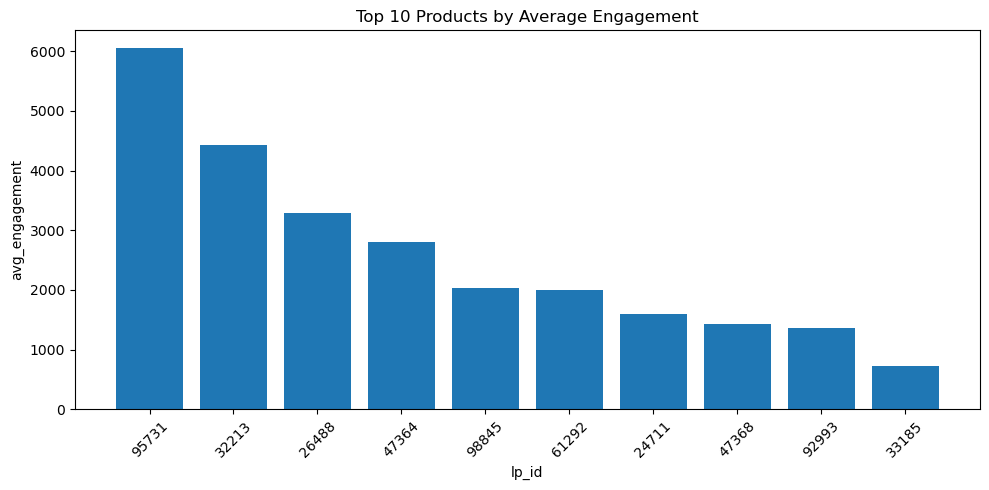

In [12]:
plt.bar(top_products["lp_id"].astype(str), top_products["avg_engagement"])
plt.title("Top 10 Products by Average Engagement")
plt.xlabel("lp_id")
plt.ylabel("avg_engagement")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Product trends for the top 3 products

Comparing a few top products over time helps distinguish steady adoption from short-lived spikes.

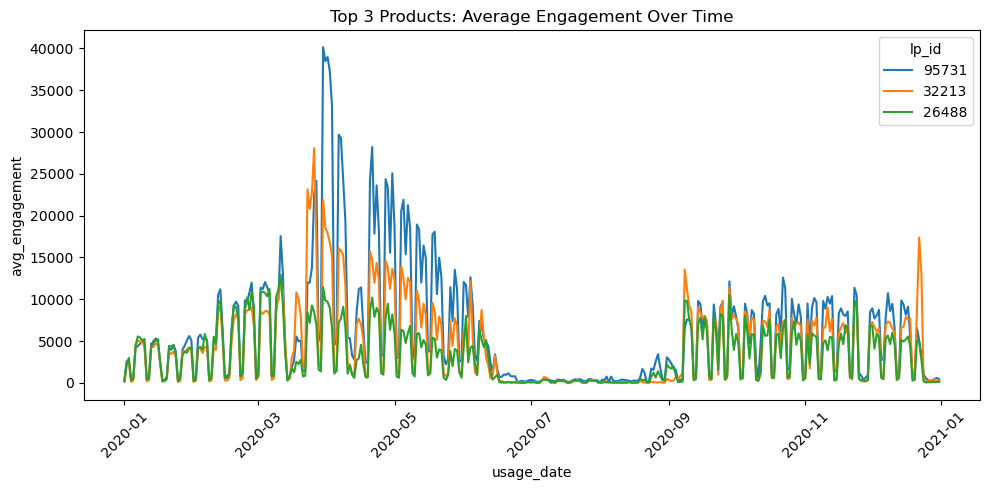

In [13]:
top3 = top_products["lp_id"].head(3).tolist()
in_list = sql_in_list(top3)

top3_trend = q(f"""
SELECT
    usage_date,
    lp_id,
    AVG(avg_engagement_index) AS avg_engagement
FROM analytics.fct_product_daily_engagement
WHERE lp_id IN {in_list} AND avg_engagement_index IS NOT NULL
GROUP BY 1, 2
ORDER BY 1, 2
""")

for lp_id in top3:
    s = top3_trend[top3_trend["lp_id"] == lp_id]
    plt.plot(s["usage_date"], s["avg_engagement"], label=str(lp_id))

plt.title("Top 3 Products: Average Engagement Over Time")
plt.xlabel("usage_date")
plt.ylabel("avg_engagement")
plt.xticks(rotation=45)
plt.legend(title="lp_id")
plt.tight_layout()
plt.show()

## 8. Engagement volatility by product

We use population standard deviation of `avg_engagement_index` as a simple volatility measure.

- **High volatility** can indicate episodic use (units, assessments) *or* inconsistent adoption.
- **Low volatility** can indicate steady usage (core curriculum) *or* consistent low usage.

We look at volatility alongside average engagement.

In [14]:
volatility = q("""
SELECT
    lp_id,
    AVG(avg_engagement_index) AS avg_engagement,
    STDDEV_POP(avg_engagement_index) AS engagement_volatility,
    CASE
        WHEN AVG(avg_engagement_index) = 0 THEN NULL
        ELSE STDDEV_POP(avg_engagement_index) / AVG(avg_engagement_index)
    END AS coeff_var
FROM analytics.fct_product_daily_engagement
WHERE lp_id IS NOT NULL AND avg_engagement_index IS NOT NULL
GROUP BY 1
ORDER BY engagement_volatility DESC
""")
volatility.head(10)

,lp_id,avg_engagement,engagement_volatility,coeff_var
0,95731,6045.558825,7022.054576,1.161523
1,32213,4429.628188,4954.613528,1.118517
2,98845,2035.109164,3480.984341,1.710466
3,26488,3292.359458,3285.251750,0.997841
4,47364,2797.406286,3035.150758,1.084987
5,24711,1590.518214,2495.542076,1.569012
6,47368,1428.268599,1654.543406,1.158426
7,92993,1369.626623,1500.524046,1.095572
8,29916,484.256875,1059.918970,2.188754
9,61292,1991.112727,970.439622,0.487386


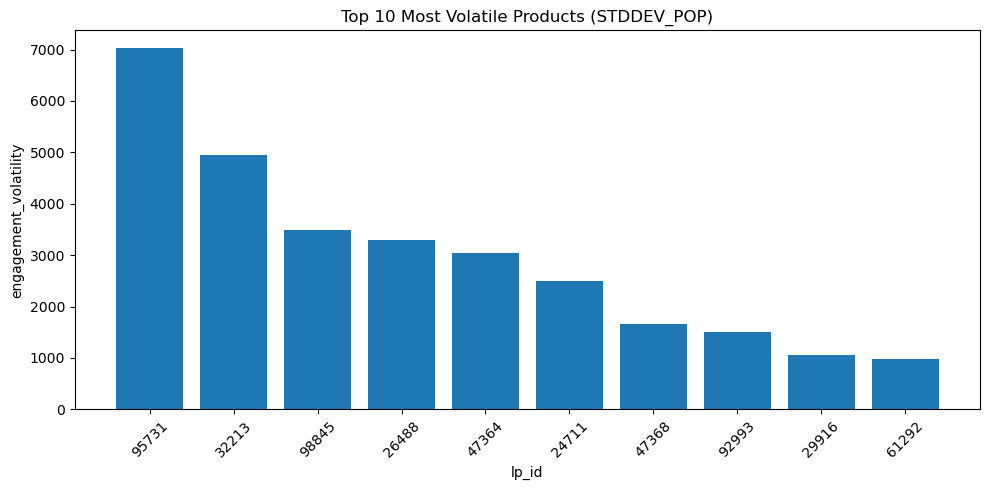

In [15]:
most_volatile = volatility.head(10).copy()
plt.bar(most_volatile["lp_id"].astype(str), most_volatile["engagement_volatility"])
plt.title("Top 10 Most Volatile Products (STDDEV_POP)")
plt.xlabel("lp_id")
plt.ylabel("engagement_volatility")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

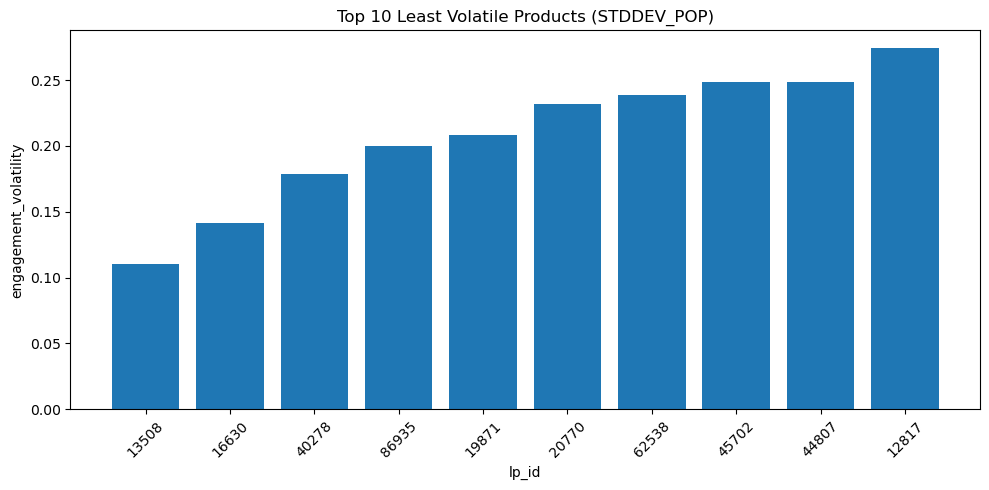

,lp_id,n_days,mean_engagement,engagement_volatility
855,13508,30,0.159500,0.110562
146,16630,42,0.185595,0.141262
582,40278,53,0.252264,0.178808
180,86935,41,0.225976,0.200052
813,19871,31,0.233871,0.208182
75,20770,41,0.226585,0.232028
430,62538,31,0.287419,0.238516
862,45702,33,0.243636,0.248167
273,44807,53,0.300755,0.248838
212,12817,32,0.255469,0.274059


In [16]:
volatility = q("""
SELECT
  lp_id,
  COUNT(*) AS n_days,
  AVG(avg_engagement_index) AS mean_engagement,
  STDDEV_POP(avg_engagement_index) AS engagement_volatility
FROM analytics.fct_product_daily_engagement
WHERE avg_engagement_index IS NOT NULL
GROUP BY lp_id
HAVING COUNT(*) >= 30
""")

least_volatile = volatility.sort_values("engagement_volatility", ascending=True).head(10).copy()

plt.bar(least_volatile["lp_id"].astype(str), least_volatile["engagement_volatility"])
plt.title("Top 10 Least Volatile Products (STDDEV_POP)")
plt.xlabel("lp_id")
plt.ylabel("engagement_volatility")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

least_volatile

In [17]:
con.close()

## 9. Interpretation & implications

**What these patterns can suggest (hypotheses):**
- If engagement is highly skewed, a small number of products may dominate usage.
- High-volatility products may be tied to specific instructional moments (e.g., assessments) or inconsistent rollout.
- Low-volatility products may be embedded into recurring workflows.

**What I would do next (data + analysis):**
- Join product metadata (subject, grade band, instructional type) to interpret *why* products differ.
- Slice by cohorts (school, grade, teacher) to see whether volatility is system-wide or localized.
- Add outcome context (e.g., completion, assessment signals) to avoid over-interpreting usage as impact.
